# Janus temporary gym environment

In [23]:
import gym
from gym import spaces
import random
import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DQN, DDPG
from math import sqrt
import numpy as np
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise


class JanusTemp(gym.Env):
    metadata = {'render.modes': ['human']}
    template_filename = 'data/dataset-S_public/public/dataset_S-{}.csv'




    def __init__(self):
        super(JanusTemp, self).__init__()
        #actions: move on the grid, by continuous value in -1,1
        #0,0 no move
        #based on 94 controlable parameters
        #"We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) ", we will multiply effect by 2
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(98, ))

        # all the observation_space
        self.observation_space = spaces.Box(low=-1.0, high=1.0, shape=(325, ))
        

    def reset(self):
        self.current_position = self.observation_space.sample()
        self.last_action = np.array([])
        self.last_effect = False
        self.global_reward = 0
        print(f'reset at position {self.current_position}')
        return self.current_position

    def step(self, action):
        action *= 2
        effect = False
        if ((action[0] + self.current_position[1] < 5) &
            (action[0] + self.current_position[1] > 0)):
            effect = True
            self.current_position[1] += action[0]
        if ((action[1] + self.current_position[0] < 5) &
            (action[1] + self.current_position[0] > 0)):
            effect = True
            self.current_position[0] += action[1]

        reward = -10

        if (self.last_action.size > 0):
            ## can be used to compare to last action if it is valid
            pass
        self.last_action = action
        self.last_effect = effect

        done = False
        if (self.current_position[0] > 4) & (self.current_position[1] > 4):
            reward = 100
            done = True
        self.global_reward += reward
        return self.current_position, reward, done, {}

    def render(self):
        print(
            f'position {self.current_position}, action {self.last_action}, effect {self.last_effect}, done {done}, global_reward {self.global_reward}'
        )

    def convert_to_real_obs(self, observation, observation_dataset):
        '''
        to convert an observation from observation space ([-1, 1],325) to  real world
        -1 matches with min() of each column
        1 matches with max() of each column
        
        observation: instance of observation_space
        observation_dataset: the full real dataset (obfuscated in that case)
        '''
        return (observation + np.ones(self.observation_space.shape)) / 2 * (
            observation_dataset.max() -
            observation_dataset.min()) + observation_dataset.min()

    def revert_to_obs_space(self, real_observation, observation_dataset):
        '''
        to revert an observation sample (from real world) to observation space
        min() of each column will match with -1
        max() of each column will match with +1
        
        real_observation: instance of real_world
        observation_dataset: the full real dataset (obfuscated in that case)
        '''
        return np.nan_to_num(
            2 * (real_observation - observation_dataset.min()) /
            (observation_dataset.max() - observation_dataset.min()) -
            np.ones(self.observation_space.shape)).reshape(-1)

# load of data

In [18]:
import numpy as np
import pandas as pd

template_filename = 'data/dataset-S_public/public/dataset_S-{}.csv'


file1 = pd.read_csv(template_filename.format('file1'), index_col=0)
file2 = pd.read_csv(template_filename.format('file2'), index_col=0)
file3 = pd.read_csv(template_filename.format('file3'), index_col=0)
vav = pd.read_csv(template_filename.format('VAV'), index_col=0)

In [19]:
print(f'valeur min dans le dataset {min(file3.min())}, \ntop 5 min \n {file3.min()[file3.min().argsort()].head(5)}')
print(f'valeur maxi dans le dataset {max(file3.max())}, \ntop 5 max \n {file3.max()[file3.max().argsort(reversed)].tail(5)}')


valeur min dans le dataset -13266.208031209428, 
top 5 min 
 data_35   -13266.208031
data_64      -81.066595
data_54      -80.048077
data_38      -58.773270
data_6       -31.377531
dtype: float64
valeur maxi dans le dataset 11187.080152500184, 
top 5 max 
 data_88      961.717861
data_87     1436.915935
data_53     1436.915935
data_63     1999.338904
data_64    11187.080153
dtype: float64


In [20]:
file3.describe()

,data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,data_9,...,data_315,data_316,data_317,data_318,data_319,data_320,data_321,data_322,data_323,data_324
count,13639.000000,13639.000000,13639.000000,13639.0,13639.0,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,...,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000
mean,0.006749,-0.042141,0.020207,0.0,0.0,-0.076367,0.012645,0.333411,0.051388,0.051303,...,-0.038504,-0.025678,-0.027770,0.055177,0.057303,0.055709,-0.031514,-0.024710,-0.006076,0.039658
std,1.252618,0.730117,1.231389,0.0,0.0,1.033150,1.006611,7.226308,1.004473,1.004542,...,0.996080,1.066681,0.991445,0.971180,1.157526,0.987968,1.006784,1.330478,0.990435,0.997304
min,-19.168525,-1.385061,-6.845543,0.0,0.0,-3.015342,-31.377531,-3.018091,-3.538492,-3.538492,...,-4.124391,-14.343231,-4.034838,-3.180928,-26.006003,-3.031386,-3.386451,-16.194757,-3.608651,-1.278469
25%,0.416824,-0.162994,-0.013106,0.0,0.0,-0.791116,-0.996154,-0.811167,-0.659694,-0.659694,...,-0.554152,-0.584948,-0.557652,-0.594019,-0.602010,-0.582388,-0.562853,-0.618133,-0.552126,-1.278469
50%,0.416824,-0.162994,-0.013106,0.0,0.0,-0.155623,0.369301,0.134657,-0.199086,-0.199086,...,0.087558,0.075623,0.105493,0.138939,0.131212,0.148015,-0.030758,-0.015981,0.012914,-0.389000
75%,0.416824,-0.122259,0.214642,0.0,0.0,0.797617,0.710665,0.765207,0.722129,0.722129,...,0.641762,0.654976,0.636008,0.656321,0.778173,0.706558,0.648925,0.604199,0.650006,0.500468
max,15.805312,10.835603,43.714493,0.0,0.0,2.386350,2.076120,129.031368,3.946383,3.946383,...,2.596059,24.099828,2.608143,3.545036,17.038454,2.854802,3.425915,75.004214,3.551050,1.389936


## convert observation space sample to real observation 

In [21]:
def convert_to_real_obs(observation, observation_dataset):
    '''
    to convert an observation from observation space ([-1, 1],325) to  real world
    -1 matches with min() of each column
    1 matches with max() of each column

    observation: instance of observation_space
    observation_dataset: the full real dataset (obfuscated in that case)
    '''
    return (observation + np.ones(len(observation))) / 2 * (
        observation_dataset.max() -
        observation_dataset.min()) + observation_dataset.min()

In [24]:
env_test = JanusTemp()
from stable_baselines3.common.env_checker import check_env

# check_env(env_test)

convert_to_real_obs(env_test.observation_space.sample(), file3)

data_0       4.471135
data_1       6.488912
data_2      -0.851254
data_3       0.000000
data_4       0.000000
              ...    
data_320     1.487549
data_321     2.626841
data_322    66.468558
data_323    -0.646418
data_324    -1.268598
Length: 325, dtype: float64

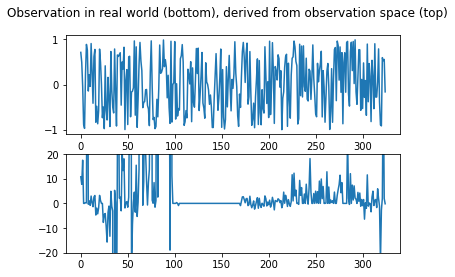

In [25]:
obs = env_test.observation_space.sample()
arr = convert_to_real_obs(obs, file3)

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Observation in real world (bottom), derived from observation space (top)')
ax2.plot(np.arange(0, len(arr)), arr)
ax2.set_ylim([-20,20])
ax1.plot(np.arange(0, len(arr)), obs)
plt.show()

## revert 

In [26]:
def revert_to_obs_space(real_observation, observation_dataset):
    '''
    to revert an observation sample (from real world) to observation space
    min() of each column will match with -1
    max() of each column will match with +1

    real_observation: instance of real_world
    observation_dataset: the full real dataset (obfuscated in that case)
    '''
    return np.nan_to_num(2 * (real_observation - observation_dataset.min()) / (
        observation_dataset.max() - observation_dataset.min()) - np.ones(
            real_observation.shape[1])).reshape(-1)

In [27]:
revert_to_obs_space(file3.sample(), file3)

array([-4.00000000e-02, -8.46666667e-01, -7.92792793e-01,  0.00000000e+00,
        0.00000000e+00, -5.88235294e-02,  7.75510204e-01, -9.61799185e-01,
        1.38461538e-01,  1.38461538e-01,  1.00000000e-01, -6.00000000e-01,
       -4.11764706e-01,  1.38461538e-01,  1.38461538e-01,  1.38461538e-01,
        5.26315789e-02,  6.66666667e-02, -3.33333333e-01,  1.07692308e-01,
        1.07692308e-01, -1.11111111e-01,  0.00000000e+00,  0.00000000e+00,
        6.50000000e-01,  6.19047619e-01,  7.36842105e-01,  2.59259259e-01,
        3.33333333e-01,  6.57142857e-01, -8.33333333e-02,  1.42857143e-01,
       -2.04081633e-02,  2.90322581e-01,  0.00000000e+00,  9.99746771e-01,
        1.11111111e-01, -2.47311828e-01,  2.91150125e-01, -1.00000000e+00,
       -1.00000000e+00,  3.10638298e-01,  7.02341137e-02,  4.83870968e-02,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -4.28571429e-01,
        1.50442478e-01,  3.41563786e-01, -8.65248227e-01,  3.82648402e-01,
       -9.66978317e-01, -

# prediction and reward calculation

## preprocessing, train, test data

In [28]:
## ML model
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.datasets import make_regression

import math
import pickle


x_df = file1.copy()
x_df = x_df.loc[:, (x_df != 0).any(axis=0)]    ## remove static columns 
x_df = x_df.fillna(x_df.mean())                ## replace nan with mean

y_df = file2.copy()
y_df.dropna(how='all', axis=1, inplace=True)   ## drop full tempty columns
y_df = y_df.fillna(y_df.mean())

vav_df = vav.copy()
# Dropping few columns
y_df.drop(['target_1', 'target_2', 'target_3', 'target_4'], axis=1, inplace=True) #to simplify with a 2-dimension target space
vav_df.drop(['target_1', 'target_2', 'target_3', 'target_4'], axis=1, inplace=True)

print('features shape: {}, \ntargets shape: {}'.format(x_df.shape, y_df.shape))

x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.1, random_state=14)
print('\nLength of train is {}, test is {}'.format(len(x_train), len(x_test)))

features shape: (782, 228), 
targets shape: (782, 2)

Length of train is 703, test is 79


In [29]:
action_columns = [col for col in x_df.columns if int(col.split('_')[-1])<=97] ##data_97 is the last Action column
print(f'Action space dimension: {len(action_columns)}')
print(f'Observation space dimension: {len(x_df.columns)}')

Action space dimension: 94
Observation space dimension: 228


## rf prediction model

In [96]:
## Model fitting

ml_model = RandomForestRegressor()   
ml_model.fit(x_train, y_train)

test_pred = ml_model.predict(x_test)

mse = mean_squared_error(y_test, test_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, test_pred)       

print('MSE: ', mse)
print('RMSE: ',rmse)
print('R-squared: ',r2)

MSE:  0.3528837782072485
RMSE:  0.5940402159847837
R-squared:  0.655023194434581


In [30]:
## ---- save/load the model to disk

## Random forest
filename = 'data/models/janus_RF.pkl'  # janus_LinearReg, janus_RF

# pickle.dump(ml_model, open(filename, 'wb'))

# # load the model from disk
ml_model = pickle.load(open(filename, 'rb'))
print(f'R squared: {ml_model.score(x_test, y_test.values):0.04f}')


R squared: 0.6550


## reward calculation

In [31]:
# list of [min, max, step, range] for each var
scale = 100
decimals = 3

## get limits for Rewards
output_steps = [round((y_df[i].max() - y_df[i].min())/scale, decimals) \
                for i in y_df.columns]
print('Output steps: ', output_steps)


def discrete_reward(new_y):
    ''' Discrete reward '''
    
    new_val = [math.sqrt((vav_df.iloc[:,i].values[0] - new_y[i])**2) for i in range(len(new_y))]
    k = 10
    k1 = 1
    if new_val[0] < k * output_steps[0] and new_val[1] < k * output_steps[1]:
        reward = 1 #dans les 10% d'amplitude max autour de la vav
        if new_val[0] < k1 * output_steps[0] and new_val[
                1] < k1 * output_steps[1]:
            reward = 10 #dans les 1% d'amplitude max autour de la vav
            on_target = True
            print('On Target : ', new_y)
    else:
        reward = -1
    return reward

#vav
print(discrete_reward([vav['target_0'].values[0], vav['target_5'].values[0]]))
#vav + 1%/2
print(discrete_reward([vav['target_0'].values[0]+output_steps[0]/2, vav['target_5'].values[0]+output_steps[0]/2]))
#vav + 5%
print(discrete_reward([vav['target_0'].values[0]+5*output_steps[0], vav['target_5'].values[0]+5*output_steps[0]]))
#vav + 10%
print(discrete_reward([vav['target_0'].values[0]+10*output_steps[0], vav['target_5'].values[0]+10*output_steps[0]]))


Output steps:  [0.064, 0.057]
On Target :  [0.984996985104684, -0.1701545241085946]
10
On Target :  [1.016996985104684, -0.1381545241085946]
10
1
-1


In [32]:
import matplotlib.pyplot as plt


def plot_targets_reward(dataset):
    targets = list(dataset.columns)
    nbr_targets = len(targets)
    fig, axes = plt.subplots(nbr_targets + 1, 1)
    fig.suptitle(str(targets) + ', reward')
    fig.set_size_inches(18.5, 10.5)
    for count, ax in enumerate(axes[:-1]):
        ax.plot(np.arange(0, len(dataset[targets[count]])),
                dataset[targets[count]],
                label=targets[count])
        ax.axhline(y=vav_df[targets[count]].values[0],
                   color='k',
                   lw=0.8,
                   ls='--',
                   label='vav')
        ax.legend()
    rewards = [discrete_reward([dataset.loc[i, targets[0]], dataset.loc[i, targets[1]]]) for i in dataset.index]
    axes[-1].plot(np.arange(0, len(dataset[targets[count]])),
                  rewards, label='reward')
    axes[-1].legend()
    print(f'Mean of reward: {np.mean(rewards)}')
    plt.show()

On Target :  [0.984996985104684, -0.1701545241085946]
Mean of reward: -0.7097186700767263


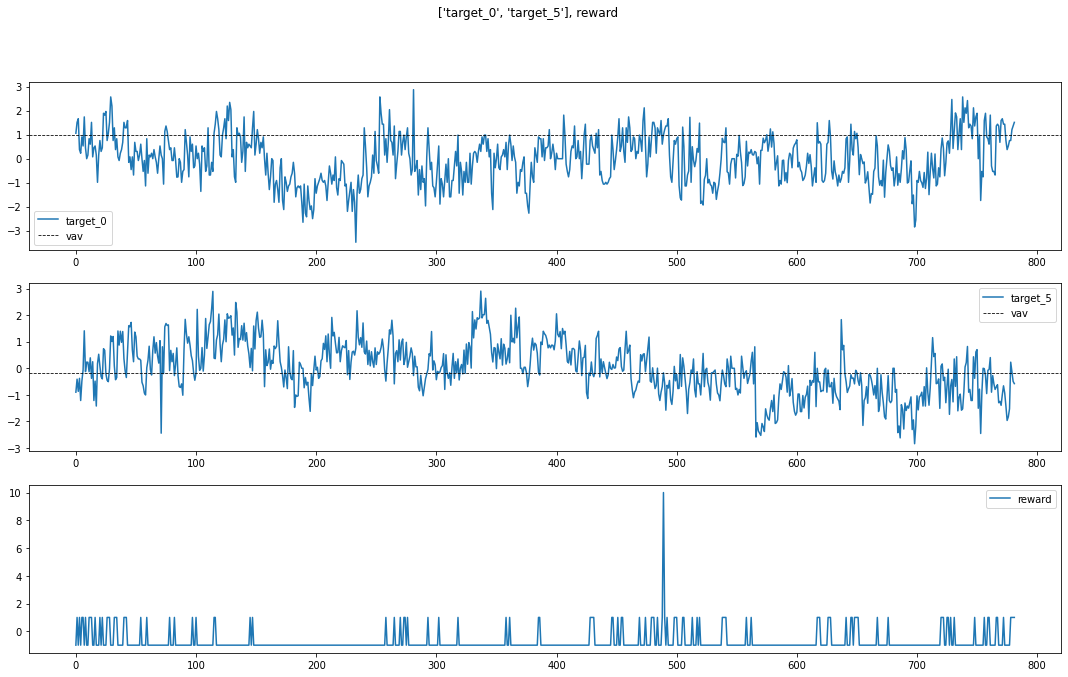

In [33]:
plot_targets_reward(y_df)

On Target :  [0.9581956980158332, -0.19580757712562744]
On Target :  [1.0039244477380531, -0.22203417401092593]
On Target :  [0.9865111821153537, -0.1447934570608634]
On Target :  [1.017400801133012, -0.14984064310161296]
On Target :  [0.9406233234103725, -0.15101901504914297]
On Target :  [1.011495432791401, -0.22146063014265863]
On Target :  [0.9675837194819842, -0.17390862942816082]
On Target :  [1.04435350792293, -0.1636891205026768]
On Target :  [0.9840884668982836, -0.14993449573460157]
On Target :  [0.9905995140441628, -0.12333248831734644]
Mean of reward: -0.7125888994794339


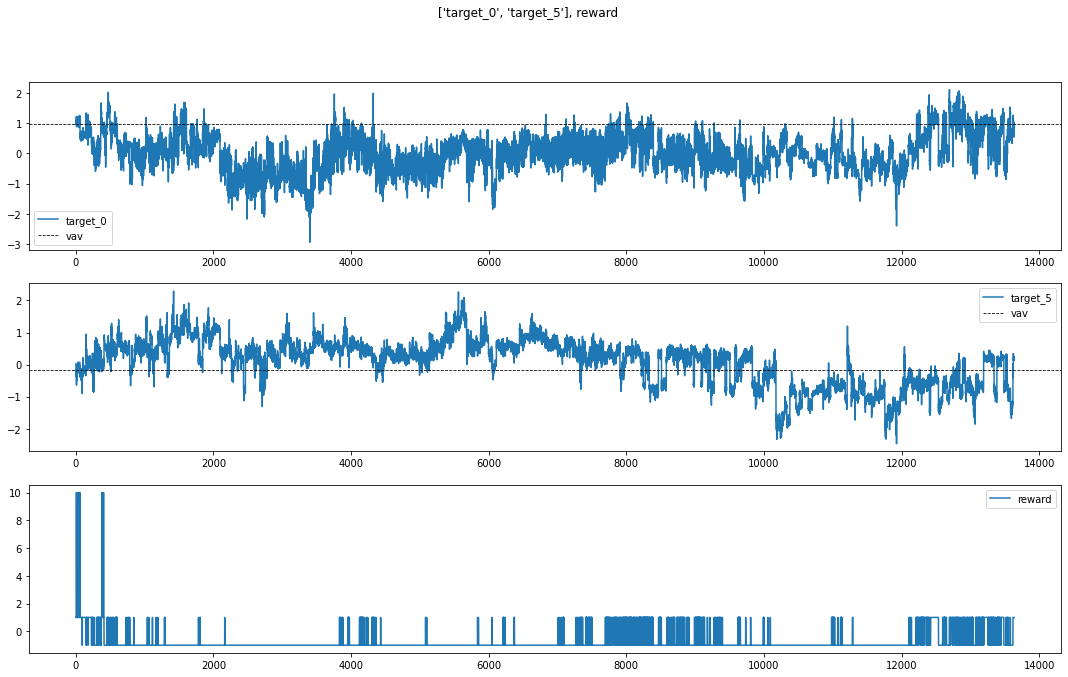

In [34]:
full_x = file3.copy()[x_df.columns]
full_x = full_x.fillna(x_df.mean()) 

inferred_y = pd.DataFrame(ml_model.predict(full_x), columns=y_df.columns)
plot_targets_reward(inferred_y)

Mean of reward: -0.7058823529411765


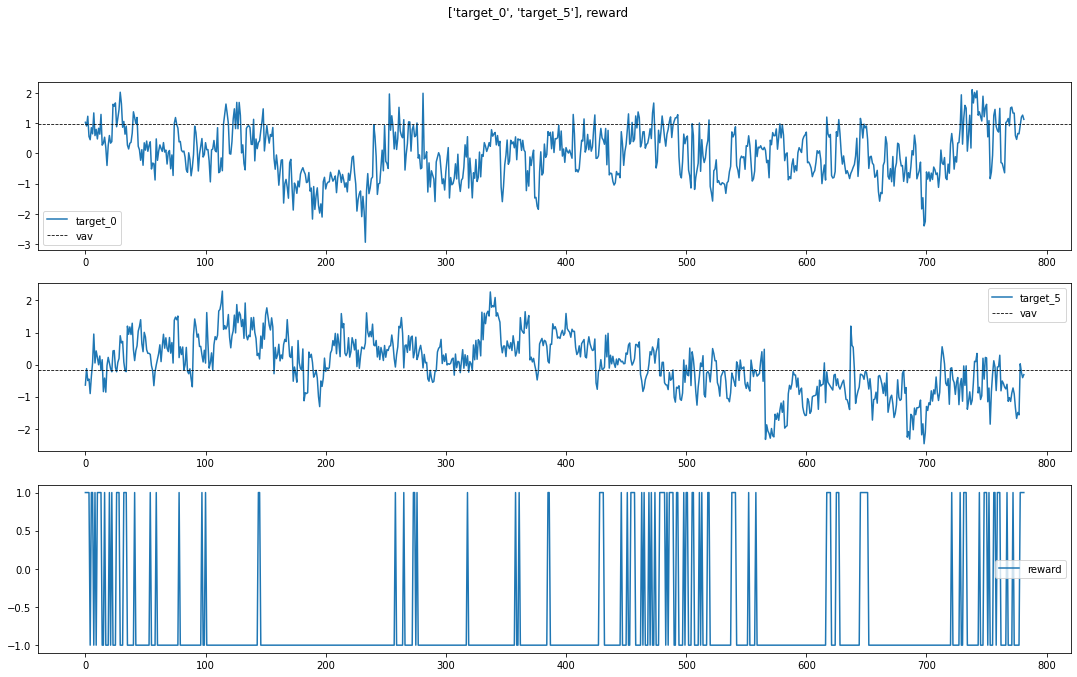

In [35]:
partial_x = file1.copy()[x_df.columns]
partial_x = partial_x.fillna(x_df.mean())

predicted_partial = pd.DataFrame(ml_model.predict(partial_x), columns=y_df.columns)
plot_targets_reward(predicted_partial)

## reward calculation based on observation

In [36]:
real_observation = full_x.sample()

print(f'real observation (sampled from full_x: {real_observation}')
predicted_y_from_obs = ml_model.predict(real_observation).reshape(-1)
print(f'predicted y from this sample {predicted_y_from_obs} {predicted_y_from_obs.shape}')
discrete_reward(predicted_y_from_obs)

real observation (sampled from full_x:          data_0    data_1    data_2    data_5    data_6    data_7   data_8  \
12913 -2.381083 -0.244465 -0.468602 -0.473369 -1.678881 -0.495893  0.14637   

        data_9   data_10   data_11  ...  data_315  data_316  data_317  \
12913  0.14637 -1.818645 -2.014329  ... -1.341704  0.324691 -1.284228   

       data_318  data_319  data_320  data_321  data_322  data_323  data_324  
12913 -0.507788 -1.550886 -1.269826  -0.06183  1.354185  0.054628 -1.278469  

[1 rows x 228 columns]
predicted y from this sample [ 0.94197841 -0.50254554] (2,)


1

In [37]:
# list of [min, max, step, range] for each var
scale = 100
decimals = 3

## get limits for Rewards
output_steps = [round((y_df[i].max() - y_df[i].min())/scale, decimals) \
                for i in y_df.columns]

def discrete_reward_from_obs(observation):
    ''' Discrete reward 
    observation if from real world not observation space
    '''
    
    new_y = ml_model.predict(observation).reshape(-1)
    return discrete_reward(new_y)

print(discrete_reward_from_obs(full_x.sample()))


-1


In [38]:
for i in range(100):
    print(discrete_reward_from_obs(full_x.sample()))

-1
-1
-1
-1
-1
-1
1
1
-1
-1
-1
-1
-1
-1
1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
1
-1
-1
-1
-1
1
1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
1
-1
1
-1
-1


# Janus gym environment

In [97]:
import gym
from gym import spaces
import random
import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DQN, DDPG
from math import sqrt
import numpy as np
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise


class Janus(gym.Env):
    metadata = {'render.modes': ['human']}
    template_filename = 'data/dataset-S_public/public/dataset_S-{}.csv'

    def __init__(self):
        super(Janus, self).__init__()
        #actions: move on the grid, by continuous value in -1,1
        #0,0 no move
        #based on 94 controlable parameters
        #"We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) ", we will multiply effect by 2
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(94, ))

        # all the observation_space
        self.observation_space = spaces.Box(low=-1.0, high=1.0, shape=(228, ))

        file1 = pd.read_csv(template_filename.format('file1'), index_col=0)
        file2 = pd.read_csv(template_filename.format('file2'), index_col=0)
        file3 = pd.read_csv(template_filename.format('file3'), index_col=0)
        vav = pd.read_csv(template_filename.format('VAV'), index_col=0)
        x_df = file1.copy()
        x_df = x_df.loc[:, (x_df != 0).any(axis=0)]  ## remove static columns
        x_df = x_df.fillna(x_df.mean())  ## replace nan with mean

        y_df = file2.copy()
        y_df.dropna(how='all', axis=1,
                    inplace=True)  ## drop full tempty columns
        y_df = y_df.fillna(y_df.mean())

        self.vav_df = vav.copy()
        # Dropping few columns
        y_df.drop(['target_1', 'target_2', 'target_3', 'target_4'],
                  axis=1,
                  inplace=True)  #to simplify with a 2-dimension target space
        self.vav_df.drop(['target_1', 'target_2', 'target_3', 'target_4'],
                         axis=1,
                         inplace=True)

        print('features shape: {}, \ntargets shape: {}'.format(
            x_df.shape, y_df.shape))

        x_train, x_test, y_train, y_test = train_test_split(x_df,
                                                            y_df,
                                                            test_size=0.1,
                                                            random_state=14)
        print('\nLength of train is {}, test is {}'.format(
            len(x_train), len(x_test)))
        ## Random forest
        filename = 'data/models/janus_RF.pkl'  # janus_LinearReg, janus_RF

        # pickle.dump(ml_model, open(filename, 'wb'))

        # # load the model from disk
        self.ml_model = pickle.load(open(filename, 'rb'))
        print(f'R squared: {self.ml_model.score(x_test, y_test.values):0.04f}')

        self.full_x = file3.copy()[x_df.columns]
        self.full_x = full_x.fillna(x_df.mean())

        inferred_y = pd.DataFrame(ml_model.predict(full_x),
                                  columns=y_df.columns)

        # list of [min, max, step, range] for each var
        scale = 100
        decimals = 3

        ## get limits for Rewards
        self.output_steps = [round((y_df[i].max() - y_df[i].min())/scale, decimals) \
                        for i in y_df.columns]
        print('Output steps: ', output_steps)

    def reset(self):
        self.current_position = self.revert_to_obs_space(
            self.full_x.sample().values.reshape(-1), self.full_x)
        self.last_action = np.array([])
        self.last_effect = False
        self.global_reward = 0
        self.episode_length = 0
        #print(f'reset at position {self.current_position[:10]}...')
        return self.current_position

    def step(self, action):
        self.current_position[0:len(action)] = action
        self.last_action = action
        self.episode_length += 1
        
        reward = self.discrete_reward_from_obs(
            self.convert_to_real_obs(self.current_position,
                                     self.full_x).values.reshape(1,-1))
        done = reward == 10
        
        if self.episode_length>100:
            #print('episode too long -> reset')
            done = True
            

        self.global_reward += reward
        return self.current_position, reward, done, {}

    def render(self):
        print(
            f'position {self.current_position[:10]}, action {self.last_action[:5]}, effect {self.last_effect}, done {done}, global_reward {self.global_reward}'
        )

    def convert_to_real_obs(self, observation, observation_dataset):
        '''
        to convert an observation from observation space ([-1, 1],325) to  real world
        -1 matches with min() of each column
        1 matches with max() of each column
        
        observation: instance of observation_space
        observation_dataset: the full real dataset (obfuscated in that case)
        '''
        return (observation + np.ones(self.observation_space.shape)) / 2 * (
            observation_dataset.max() -
            observation_dataset.min()) + observation_dataset.min()

    def revert_to_obs_space(self, real_observation, observation_dataset):
        '''
        to revert an observation sample (from real world) to observation space
        min() of each column will match with -1
        max() of each column will match with +1
        
        real_observation: instance of real_world
        observation_dataset: the full real dataset (obfuscated in that case)
        '''
        return np.nan_to_num(
            2 * (real_observation - observation_dataset.min()) /
            (observation_dataset.max() - observation_dataset.min()) -
            np.ones(self.observation_space.shape)).reshape(-1)

    def discrete_reward_from_obs(self, observation):
        ''' Discrete reward 
        observation if from real world not observation space
        '''

        new_y = self.ml_model.predict(observation).reshape(-1)
        return self.discrete_reward(new_y)

    def discrete_reward(self, new_y):
        ''' Discrete reward '''

        new_val = [
            sqrt((self.vav_df.iloc[:, i].values[0] - new_y[i])**2)
            for i in range(len(new_y))
        ]
        k = 10
        k1 = 1
        if new_val[0] < k * self.output_steps[0] and new_val[
                1] < k * self.output_steps[1]:
            reward = 1  #dans les 10% d'amplitude max autour de la vav
            if new_val[0] < k1 * self.output_steps[0] and new_val[
                    1] < k1 * self.output_steps[1]:
                reward = 10  #dans les 1% d'amplitude max autour de la vav
                on_target = True


#                 print('On Target : ', new_y)
        else:
            reward = -1
        return reward

In [98]:
janus_env = Janus()
from stable_baselines3.common.env_checker import check_env

check_env(janus_env)

features shape: (782, 228), 
targets shape: (782, 2)

Length of train is 703, test is 79
R squared: 0.6550
Output steps:  [0.064, 0.057]


# SAC training

In [99]:
from stable_baselines3 import SAC

janus_env = Janus()
check_env(janus_env)

model_janus_sac = SAC("MlpPolicy", janus_env, verbose=2,tensorboard_log="./tensorboard/")
model_janus_sac.learn(total_timesteps=100000, log_interval=4, tb_log_name="janus sac")

janus_env.reset()
for i in range(100):
    action, _ = model_janus_sac.predict(janus_env.current_position)
    print(f'action {action}')
    obs, rewards, done, info = janus_env.step(action)
    janus_env.render()
    if done: break
janus_env.close()

features shape: (782, 228), 
targets shape: (782, 2)

Length of train is 703, test is 79
R squared: 0.6550
Output steps:  [0.064, 0.057]
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard/janus sac_5
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -55      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 25       |
|    time_elapsed    | 15       |
|    total timesteps | 404      |
| train/             |          |
|    actor_loss      | -146     |
|    critic_loss     | 81.3     |
|    ent_coef        | 0.914    |
|    ent_coef_loss   | -13.6    |
|    learning_rate   | 0.0003   |
|    n_updates       | 303      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -53.2    |
| time/          

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -79.2     |
| time/              |           |
|    episodes        | 60        |
|    fps             | 22        |
|    time_elapsed    | 272       |
|    total timesteps | 6060      |
| train/             |           |
|    actor_loss      | -6.65e+03 |
|    critic_loss     | 4.56e+05  |
|    ent_coef        | 1.09      |
|    ent_coef_loss   | -6.15     |
|    learning_rate   | 0.0003    |
|    n_updates       | 5959      |
----------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99.5     |
|    ep_rew_mean     | -78.8    |
| time/              |          |
|    episodes        | 64       |
|    fps             | 22       |
|    time_elapsed    | 284      |
|    total timesteps | 6366     |
| train/             |          |
|    actor_loss      | -7.9e+03 |
|    critic_loss     | 3.7e+05 

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -79.5     |
| time/              |           |
|    episodes        | 116       |
|    fps             | 22        |
|    time_elapsed    | 507       |
|    total timesteps | 11618     |
| train/             |           |
|    actor_loss      | -5.04e+04 |
|    critic_loss     | 1.91e+07  |
|    ent_coef        | 5.9       |
|    ent_coef_loss   | -99.3     |
|    learning_rate   | 0.0003    |
|    n_updates       | 11517     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -79.6     |
| time/              |           |
|    episodes        | 120       |
|    fps             | 22        |
|    time_elapsed    | 524       |
|    total timesteps | 12022     |
| train/             |           |
|    actor_loss      | -5.59e+04 |
|    critic_loss    

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -77.8     |
| time/              |           |
|    episodes        | 172       |
|    fps             | 23        |
|    time_elapsed    | 746       |
|    total timesteps | 17274     |
| train/             |           |
|    actor_loss      | -1.33e+05 |
|    critic_loss     | 1.47e+08  |
|    ent_coef        | 20.8      |
|    ent_coef_loss   | -30.4     |
|    learning_rate   | 0.0003    |
|    n_updates       | 17173     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -76.8     |
| time/              |           |
|    episodes        | 176       |
|    fps             | 23        |
|    time_elapsed    | 763       |
|    total timesteps | 17678     |
| train/             |           |
|    actor_loss      | -1.38e+05 |
|    critic_loss    

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -78.5     |
| time/              |           |
|    episodes        | 228       |
|    fps             | 23        |
|    time_elapsed    | 979       |
|    total timesteps | 22930     |
| train/             |           |
|    actor_loss      | -2.31e+05 |
|    critic_loss     | 5.1e+08   |
|    ent_coef        | 34.2      |
|    ent_coef_loss   | 7.31      |
|    learning_rate   | 0.0003    |
|    n_updates       | 22829     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -76.7     |
| time/              |           |
|    episodes        | 232       |
|    fps             | 23        |
|    time_elapsed    | 996       |
|    total timesteps | 23334     |
| train/             |           |
|    actor_loss      | -2.39e+05 |
|    critic_loss    

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -82       |
| time/              |           |
|    episodes        | 284       |
|    fps             | 23        |
|    time_elapsed    | 1204      |
|    total timesteps | 28586     |
| train/             |           |
|    actor_loss      | -3.45e+05 |
|    critic_loss     | 1.49e+09  |
|    ent_coef        | 50.4      |
|    ent_coef_loss   | -8.51     |
|    learning_rate   | 0.0003    |
|    n_updates       | 28485     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -83.1     |
| time/              |           |
|    episodes        | 288       |
|    fps             | 23        |
|    time_elapsed    | 1220      |
|    total timesteps | 28990     |
| train/             |           |
|    actor_loss      | -3.45e+05 |
|    critic_loss    

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -80.6     |
| time/              |           |
|    episodes        | 340       |
|    fps             | 23        |
|    time_elapsed    | 1428      |
|    total timesteps | 34242     |
| train/             |           |
|    actor_loss      | -4.44e+05 |
|    critic_loss     | 3.77e+09  |
|    ent_coef        | 64.3      |
|    ent_coef_loss   | -5.21     |
|    learning_rate   | 0.0003    |
|    n_updates       | 34141     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -79.5     |
| time/              |           |
|    episodes        | 344       |
|    fps             | 23        |
|    time_elapsed    | 1446      |
|    total timesteps | 34646     |
| train/             |           |
|    actor_loss      | -4.55e+05 |
|    critic_loss    

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -76.1     |
| time/              |           |
|    episodes        | 396       |
|    fps             | 23        |
|    time_elapsed    | 1668      |
|    total timesteps | 39898     |
| train/             |           |
|    actor_loss      | -5.56e+05 |
|    critic_loss     | 1.24e+08  |
|    ent_coef        | 76        |
|    ent_coef_loss   | 3.91      |
|    learning_rate   | 0.0003    |
|    n_updates       | 39797     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -76.8     |
| time/              |           |
|    episodes        | 400       |
|    fps             | 23        |
|    time_elapsed    | 1685      |
|    total timesteps | 40302     |
| train/             |           |
|    actor_loss      | -5.68e+05 |
|    critic_loss    

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -73.3     |
| time/              |           |
|    episodes        | 452       |
|    fps             | 23        |
|    time_elapsed    | 1904      |
|    total timesteps | 45554     |
| train/             |           |
|    actor_loss      | -6.53e+05 |
|    critic_loss     | 5.32e+09  |
|    ent_coef        | 86.3      |
|    ent_coef_loss   | 7.29      |
|    learning_rate   | 0.0003    |
|    n_updates       | 45453     |
----------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -75.3    |
| time/              |          |
|    episodes        | 456      |
|    fps             | 23       |
|    time_elapsed    | 1922     |
|    total timesteps | 45958    |
| train/             |          |
|    actor_loss      | -6.6e+05 |
|    critic_loss     | 5.33e+09

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -78.1     |
| time/              |           |
|    episodes        | 508       |
|    fps             | 23        |
|    time_elapsed    | 2152      |
|    total timesteps | 51136     |
| train/             |           |
|    actor_loss      | -7.14e+05 |
|    critic_loss     | 4.23e+09  |
|    ent_coef        | 93.5      |
|    ent_coef_loss   | 7.42      |
|    learning_rate   | 0.0003    |
|    n_updates       | 51035     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -78.1     |
| time/              |           |
|    episodes        | 512       |
|    fps             | 23        |
|    time_elapsed    | 2170      |
|    total timesteps | 51540     |
| train/             |           |
|    actor_loss      | -7.24e+05 |
|    critic_loss    

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -80.4     |
| time/              |           |
|    episodes        | 564       |
|    fps             | 23        |
|    time_elapsed    | 2399      |
|    total timesteps | 56792     |
| train/             |           |
|    actor_loss      | -7.77e+05 |
|    critic_loss     | 5.2e+09   |
|    ent_coef        | 101       |
|    ent_coef_loss   | -3.61     |
|    learning_rate   | 0.0003    |
|    n_updates       | 56691     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -81.4     |
| time/              |           |
|    episodes        | 568       |
|    fps             | 23        |
|    time_elapsed    | 2416      |
|    total timesteps | 57196     |
| train/             |           |
|    actor_loss      | -7.82e+05 |
|    critic_loss    

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -79.8     |
| time/              |           |
|    episodes        | 620       |
|    fps             | 23        |
|    time_elapsed    | 2628      |
|    total timesteps | 62448     |
| train/             |           |
|    actor_loss      | -8.28e+05 |
|    critic_loss     | 4.4e+08   |
|    ent_coef        | 110       |
|    ent_coef_loss   | -5.42     |
|    learning_rate   | 0.0003    |
|    n_updates       | 62347     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -83.8     |
| time/              |           |
|    episodes        | 624       |
|    fps             | 23        |
|    time_elapsed    | 2644      |
|    total timesteps | 62852     |
| train/             |           |
|    actor_loss      | -8.33e+05 |
|    critic_loss    

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -71.1     |
| time/              |           |
|    episodes        | 676       |
|    fps             | 23        |
|    time_elapsed    | 2854      |
|    total timesteps | 68104     |
| train/             |           |
|    actor_loss      | -8.71e+05 |
|    critic_loss     | 6.37e+09  |
|    ent_coef        | 118       |
|    ent_coef_loss   | 6.43      |
|    learning_rate   | 0.0003    |
|    n_updates       | 68003     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -68.9     |
| time/              |           |
|    episodes        | 680       |
|    fps             | 23        |
|    time_elapsed    | 2870      |
|    total timesteps | 68508     |
| train/             |           |
|    actor_loss      | -8.82e+05 |
|    critic_loss    

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -68.5     |
| time/              |           |
|    episodes        | 732       |
|    fps             | 23        |
|    time_elapsed    | 3087      |
|    total timesteps | 73760     |
| train/             |           |
|    actor_loss      | -9.11e+05 |
|    critic_loss     | 1.4e+10   |
|    ent_coef        | 127       |
|    ent_coef_loss   | 5.97      |
|    learning_rate   | 0.0003    |
|    n_updates       | 73659     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -70.5     |
| time/              |           |
|    episodes        | 736       |
|    fps             | 23        |
|    time_elapsed    | 3103      |
|    total timesteps | 74164     |
| train/             |           |
|    actor_loss      | -9.02e+05 |
|    critic_loss    

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -72.9     |
| time/              |           |
|    episodes        | 788       |
|    fps             | 23        |
|    time_elapsed    | 3318      |
|    total timesteps | 79416     |
| train/             |           |
|    actor_loss      | -9.29e+05 |
|    critic_loss     | 3.12e+09  |
|    ent_coef        | 129       |
|    ent_coef_loss   | 14.4      |
|    learning_rate   | 0.0003    |
|    n_updates       | 79315     |
----------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -74.3    |
| time/              |          |
|    episodes        | 792      |
|    fps             | 23       |
|    time_elapsed    | 3335     |
|    total timesteps | 79820    |
| train/             |          |
|    actor_loss      | -9.3e+05 |
|    critic_loss     | 4.34e+09

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -83.2     |
| time/              |           |
|    episodes        | 844       |
|    fps             | 23        |
|    time_elapsed    | 3550      |
|    total timesteps | 85072     |
| train/             |           |
|    actor_loss      | -9.43e+05 |
|    critic_loss     | 1.94e+10  |
|    ent_coef        | 135       |
|    ent_coef_loss   | -10.4     |
|    learning_rate   | 0.0003    |
|    n_updates       | 84971     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -82       |
| time/              |           |
|    episodes        | 848       |
|    fps             | 23        |
|    time_elapsed    | 3567      |
|    total timesteps | 85476     |
| train/             |           |
|    actor_loss      | -9.79e+05 |
|    critic_loss    

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -86.1     |
| time/              |           |
|    episodes        | 900       |
|    fps             | 24        |
|    time_elapsed    | 3776      |
|    total timesteps | 90728     |
| train/             |           |
|    actor_loss      | -9.83e+05 |
|    critic_loss     | 6.57e+09  |
|    ent_coef        | 137       |
|    ent_coef_loss   | 19.3      |
|    learning_rate   | 0.0003    |
|    n_updates       | 90627     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -85.4     |
| time/              |           |
|    episodes        | 904       |
|    fps             | 24        |
|    time_elapsed    | 3792      |
|    total timesteps | 91132     |
| train/             |           |
|    actor_loss      | -9.75e+05 |
|    critic_loss    

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -78.4     |
| time/              |           |
|    episodes        | 956       |
|    fps             | 24        |
|    time_elapsed    | 3999      |
|    total timesteps | 96384     |
| train/             |           |
|    actor_loss      | -1.01e+06 |
|    critic_loss     | 1.73e+10  |
|    ent_coef        | 139       |
|    ent_coef_loss   | 0.586     |
|    learning_rate   | 0.0003    |
|    n_updates       | 96283     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -78.4     |
| time/              |           |
|    episodes        | 960       |
|    fps             | 24        |
|    time_elapsed    | 4015      |
|    total timesteps | 96788     |
| train/             |           |
|    actor_loss      | -1.01e+06 |
|    critic_loss    

position [-0.91315365 -0.97351652 -0.88634819  0.97787285  0.55160248  0.54891491
 -0.89815319 -0.81145704 -0.89185506  0.77248132], action [-0.91315365 -0.9735165  -0.8863482   0.97787285  0.5516025 ], effect False, done False, global_reward -8
action [-0.6054425  -0.99250484 -0.82210857  0.6251743   0.11189544  0.91370773
 -0.97542274 -0.8952674  -0.39419675  0.786042    0.8967571   0.24671674
 -0.9906647   0.24781895 -0.9758197  -0.9873274   0.9513552   0.07253861
  0.43204427 -0.9846435  -0.60783064  0.98156476  0.96806717 -0.5707812
 -0.12387699  0.22098851  0.9999571  -0.9709026  -0.83153033 -0.5484692
  0.7700989  -0.5114237  -0.66684395 -0.99431497  0.8662119   0.9649732
 -0.9363373  -0.9043643  -0.87770706  0.47569418  0.62664175  0.53662395
  0.87029505 -0.557872   -0.97332805 -0.9623965  -0.8556561  -0.9151374
 -0.7966595   0.9752003   0.75077176 -0.987554    0.2543161   0.36075044
 -0.10285032 -0.75681305  0.99541676 -0.7635474   0.99086607  0.7927222
  0.61238086 -0.595515

position [-0.90071118 -0.98785472  0.36043108  0.53919935  0.17592907  0.39469624
 -0.89498019 -0.98113722 -0.84174597  0.82273066], action [-0.9007112  -0.9878547   0.36043108  0.53919935  0.17592907], effect False, done False, global_reward -16
action [-0.36920428 -0.9976026  -0.9342818  -0.12574494 -0.49174678 -0.09335428
 -0.9863522  -0.69629174 -0.67885715 -0.03078812  0.5294666   0.20021844
 -0.28992862  0.8138242  -0.9954545  -0.94663376  0.6893544  -0.515387
  0.44351172 -0.9153529  -0.1216743   0.9666556   0.9839287  -0.68833566
  0.8985077   0.5104444   0.9869002  -0.91477334 -0.7452221   0.79103875
  0.91725516 -0.11510456 -0.3392055  -0.96937853  0.91440916  0.95301604
 -0.86933875 -0.9592242  -0.9373453   0.09090364  0.40119088  0.8646953
  0.98192286 -0.9408379  -0.87981474 -0.9116448  -0.68653977 -0.9692066
 -0.96532893  0.95599425  0.9534621  -0.9739359   0.95668316  0.24827933
  0.6122726  -0.99084866  0.93656456 -0.7470416   0.9523494   0.37411857
  0.8626555  -0.1231

position [-0.85059965 -0.96566939 -0.73136961 -0.29048187  0.917135   -0.39403903
 -0.99751115 -0.88422346 -0.99153155  0.94672573], action [-0.85059965 -0.9656694  -0.7313696  -0.29048187  0.917135  ], effect False, done False, global_reward -24
action [-0.72197866 -0.75172675 -0.7927061   0.86627364  0.43380404  0.9793236
 -0.9795799  -0.9735317  -0.6447238   0.9133096   0.96122193 -0.1770829
  0.2186054   0.914788   -0.9336584  -0.90959287  0.9459833  -0.45836353
 -0.7773309   0.36827278 -0.52707833  0.99866295  0.54170465 -0.62930393
  0.8865516   0.46725106  0.9997208  -0.96786726 -0.908934    0.53343606
  0.4972998  -0.65886295  0.9977448  -0.940509   -0.068304    0.9965322
 -0.9801551  -0.94466007 -0.9911678  -0.6116129  -0.2697276   0.97815156
  0.95628405 -0.9892499  -0.51209    -0.9918882  -0.9778399  -0.99431676
 -0.5627575   0.9878217   0.92200565 -0.92452127  0.9402151   0.5855621
  0.9815955  -0.9739083   0.9997835  -0.978159    0.868943    0.79332316
  0.9785963  -0.9690

position [-0.89457977 -0.99778426 -0.4778316   0.80172884  0.68099618 -0.18005925
 -0.98716366 -0.73121136 -0.92864794 -0.10756207], action [-0.89457977 -0.99778426 -0.4778316   0.80172884  0.6809962 ], effect False, done False, global_reward -32
action [-0.98974234 -0.8738843  -0.91487616 -0.4386369   0.65184855 -0.38382256
 -0.9873458  -0.96873635 -0.85311097 -0.14727443  0.97632086 -0.01689839
 -0.17826337  0.15025258 -0.97791374 -0.63897896  0.3331231   0.5383347
 -0.9526846   0.53830683 -0.18366116  0.98544073  0.8970108  -0.56797874
  0.93944025  0.53663886  0.9984541  -0.56233543 -0.9901777   0.8506415
  0.9338639   0.5241108   0.70300543 -0.9747009   0.9666283   0.259385
 -0.72340596 -0.98957044 -0.60916984 -0.9070007   0.48377895 -0.00993919
  0.98758245 -0.96661955 -0.9277051  -0.92477626 -0.98454607 -0.9765237
 -0.8722245   0.6808467   0.98603725 -0.9580688   0.446908    0.10555589
  0.8681588  -0.97156775  0.966046   -0.9981339   0.9640871  -0.257205
  0.83430815 -0.9765839

position [-0.95885414 -0.98838949 -0.3027761   0.79804957 -0.56651282  0.86169195
 -0.93371779 -0.91291994 -0.78556681  0.4500463 ], action [-0.95885414 -0.9883895  -0.3027761   0.79804957 -0.5665128 ], effect False, done False, global_reward -40
action [-0.96994793 -0.99161845 -0.86748224  0.85233736  0.76594734  0.711656
 -0.8763764  -0.9037379  -0.9779031   0.3694235   0.72095704 -0.8173363
 -0.8791941   0.15453029 -0.9359673  -0.44128776  0.9964521  -0.90848213
  0.52559924 -0.91079146 -0.8802789   0.999037    0.9700446  -0.77285
  0.7196226   0.61671257  0.9834703  -0.87574583 -0.9840387   0.49198294
  0.9491422   0.24006307  0.79436994 -0.8460921   0.7049217   0.90839005
 -0.95809174 -0.9986507  -0.9921736   0.84200203  0.8149432   0.9814215
  0.7409415  -0.7933747  -0.98485315 -0.95676756 -0.937754   -0.9518861
 -0.9922533   0.8369894   0.22900581 -0.85187817  0.99551344  0.91551137
  0.9322444  -0.9920831   0.96235585 -0.750929    0.54612565 -0.7321017
  0.9887979  -0.4346103  

position [-0.98691022 -0.75164598 -0.70448005  0.80091345  0.82059264 -0.11837476
 -0.78066337 -0.92997098 -0.96165133 -0.22285664], action [-0.9869102  -0.751646   -0.70448005  0.80091345  0.82059264], effect False, done False, global_reward -48
action [-0.9897539  -0.9938224  -0.8224022   0.07258344  0.37641215  0.84028816
 -0.9976258  -0.8896394  -0.8615617   0.9524498   0.5837829  -0.8281464
 -0.96053165  0.38632607 -0.97390985 -0.55755377  0.6788453  -0.6257316
  0.6580627  -0.7253944  -0.70333266  0.98622465  0.69903624 -0.98644173
  0.8299426   0.85116625  0.9991169  -0.93540305 -0.81827396 -0.7537543
  0.95205057  0.08612001 -0.7491817  -0.7320164   0.9061723   0.8733914
 -0.4243672  -0.9952283  -0.99424696  0.53635263 -0.5715399   0.87499905
  0.9853473   0.33339798 -0.9737856  -0.9853765  -0.88840055 -0.990871
 -0.7945188   0.93995154  0.9451796  -0.9478165   0.9285114   0.50628924
  0.9626081  -0.9040995   0.99240553 -0.9759384   0.9439473  -0.22139859
  0.44456744 -0.920663

position [-0.79400831 -0.87732893 -0.67081749  0.8432126   0.59258032  0.34016895
 -0.99176425 -0.91962469 -0.52243376  0.58979154], action [-0.7940083  -0.87732893 -0.6708175   0.8432126   0.5925803 ], effect False, done False, global_reward -56
action [-0.22240698 -0.9458083  -0.96049196 -0.46902227 -0.17733938  0.9783914
 -0.9901868  -0.9646268  -0.9255053  -0.23069721  0.73453486 -0.18487233
 -0.9896661   0.37004364 -0.97736245 -0.99425924  0.88706994  0.71864605
 -0.5043957  -0.8567328   0.11186171  0.9978391   0.38776577 -0.9713274
  0.97973275 -0.10181141  0.97203445 -0.6853787  -0.49371326  0.55728316
  0.95963633  0.09023511  0.7303406  -0.96005756  0.6519511   0.933954
  0.01377034 -0.99267673 -0.9762059  -0.7191708  -0.208588    0.9889339
  0.84112835 -0.48953742 -0.9509989  -0.988747   -0.93770784 -0.9836528
 -0.95153445  0.64446735  0.99027884 -0.9378972   0.706851    0.94439006
 -0.13227284 -0.9388139   0.8953568  -0.8702133   0.9210664  -0.7284295
  0.84629107 -0.4838003

position [-9.92670417e-01 -9.27981496e-01 -8.77770543e-01  2.48497605e-01
  4.44500208e-01  4.30583954e-04 -9.97656167e-01 -7.70557523e-01
 -7.48294473e-01  9.13878679e-02], action [-0.9926704  -0.9279815  -0.87777054  0.2484976   0.4445002 ], effect False, done False, global_reward -64
action [-0.9709083  -0.96325266 -0.9402662  -0.72083116  0.88439894  0.47009563
 -0.9559834  -0.974678   -0.94704235  0.9031602   0.6102835  -0.81220704
 -0.36629605  0.7822491  -0.9922862  -0.98396224  0.96107745 -0.33061224
 -0.13886356 -0.8146873  -0.96135813  0.99773455  0.97418773 -0.97467464
  0.99517274  0.35983157  0.870381   -0.9860887  -0.9422059   0.06652963
  0.8125038  -0.3690613   0.45204663 -0.82875437  0.9323226   0.9670074
 -0.53338796 -0.9700872  -0.99943465  0.6059184  -0.07701719  0.9360583
  0.91165817  0.02712417 -0.969723   -0.9871454  -0.91746116 -0.8894246
 -0.9257475  -0.18524194  0.56983244 -0.9561343   0.17282557  0.6702424
  0.9651065  -0.68484473  0.92827606 -0.992816    0.

position [-0.95375252 -0.89007759 -0.86785412  0.40111589  0.95668101  0.64199388
 -0.99158424 -0.92126882 -0.89351749 -0.51625818], action [-0.9537525 -0.8900776 -0.8678541  0.4011159  0.956681 ], effect False, done False, global_reward -72
action [-0.9551931  -0.98953587 -0.75164926  0.2241844   0.9695916  -0.63047034
 -0.9989882  -0.93260413 -0.9645842   0.94707346 -0.36667967 -0.56782794
 -0.9791833   0.8646574  -0.99260694 -0.9227851   0.89220405 -0.04667157
 -0.622196   -0.89577866 -0.8613455   0.99772537  0.9718981  -0.9357739
  0.11860895  0.86592865  0.99416757 -0.9402624  -0.9473768   0.5314801
  0.92199934  0.24051714  0.97683334 -0.93344635  0.7434366   0.98773694
 -0.95734257 -0.9214724  -0.99532294 -0.1942023  -0.9047659   0.83440936
  0.88537264 -0.90940225 -0.9771016  -0.9978191  -0.81958914 -0.9944097
 -0.7451968   0.9231503   0.6233963  -0.962879    0.9341645   0.6751214
  0.31482553 -0.62077326  0.8060279  -0.8551837   0.9016268   0.98232293
  0.9869118  -0.845857   

position [-0.81540692 -0.8779707  -0.55053222  0.73482692  0.67246675  0.86859345
 -0.64602745 -0.95441729 -0.69159222  0.7172451 ], action [-0.8154069  -0.8779707  -0.5505322   0.7348269   0.67246675], effect False, done False, global_reward -80
action [-0.9604477  -0.9859392  -0.97411954  0.88613033 -0.25529462  0.8505808
 -0.9054514  -0.46439195 -0.9099656   0.74292016  0.55972016 -0.36001134
 -0.6344794   0.30235744 -0.9899205  -0.87471634  0.97624946 -0.97250795
  0.9963145  -0.9724468  -0.87334925  0.99599075  0.80305505 -0.97917473
 -0.8419361  -0.43832612  0.9928578  -0.88125587 -0.96408     0.34932876
  0.9838501  -0.21903998  0.36558318 -0.93924975  0.940223    0.9948902
 -0.86641645 -0.97362    -0.9357707   0.6526723  -0.34104103  0.917742
  0.86949563 -0.8708847  -0.90838444 -0.9763916  -0.87321335 -0.71540356
 -0.98875684  0.9730618   0.383955   -0.93736917  0.9894309   0.09347939
  0.86630857 -0.6691846   0.98106587 -0.76367414  0.9854429   0.93208694
  0.9209671  -0.9535

position [-0.93902284 -0.96719766  0.12894249  0.88766515  0.18024111  0.61845386
 -0.99287832 -0.97932303 -0.97191429 -0.31135583], action [-0.93902284 -0.96719766  0.12894249  0.88766515  0.18024111], effect False, done False, global_reward -88
action [-0.97622764 -0.96963346 -0.8396585  -0.71856165  0.9939555   0.29086542
 -0.9411622  -0.90215784 -0.89487356  0.79083145  0.9507084  -0.295887
 -0.6056062   0.5085826  -0.99685055 -0.94987243  0.87156284 -0.8522414
 -0.09908694 -0.9746935  -0.9363473   0.99664974  0.5114963  -0.9565842
  0.9662349  -0.27215707  0.95431185 -0.8647651  -0.8914831  -0.3161844
  0.9389814  -0.883536    0.31979907 -0.98271215  0.7677486   0.9179356
  0.11671829 -0.9776035  -0.99945325 -0.27619714  0.09404647  0.83845925
  0.97207355 -0.156466   -0.99870604 -0.9989638  -0.8102286  -0.97161555
 -0.9932665   0.9861262   0.6643305  -0.77564055  0.9293709   0.55635774
  0.6203259  -0.9727881   0.95653033 -0.99651355  0.96234024  0.17532039
  0.76586807 -0.992325

position [-0.97542465 -0.99903727 -0.90976036  0.94122839  0.98305595  0.31881511
 -0.3399353  -0.95507634 -0.64729208  0.80844963], action [-0.97542465 -0.99903727 -0.90976036  0.9412284   0.98305595], effect False, done False, global_reward -96
action [-0.9136547  -0.9975225  -0.86186296  0.74062943  0.21647882 -0.8428511
 -0.9736194  -0.59658575 -0.9895262   0.9045197   0.95278335 -0.5875703
  0.22803295 -0.45043302 -0.9561915  -0.9190606   0.94422996 -0.9182496
  0.3592223  -0.94626004 -0.1479969   0.9986937   0.4848379  -0.28032124
  0.16825843  0.9188709   0.9988655  -0.9951749  -0.92351544 -0.8643004
  0.9083123  -0.9546892   0.5775062  -0.96738744  0.49042535  0.92316914
 -0.8670525  -0.9150555  -0.99744093  0.6767278   0.8888829   0.96365166
  0.97567177 -0.99073946 -0.89950246 -0.9782596  -0.68811524 -0.9785959
 -0.5075309   0.9801378   0.96883667 -0.5840422   0.8458171  -0.43717623
  0.9803771  -0.72387284  0.99522614 -0.92939585  0.98174036  0.27392793
  0.9910052  -0.81310